<a href="https://colab.research.google.com/github/sajidcsecu/radioGenomic/blob/main/UnetinGPU_(Fifty_Fifty_Preprocessed_Uniform_Volume_DiceLoss_And_Strong_Augmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the Code for the Segmentation on Rider Dataset (LUNG1). The Code is worked on the 2D slices over GPU. The balanced sampler, preprocessed data (uniform volume spacing and clipping [-1350-150]) and the strong augmentation is used in the code...

# (1) Import Required Libraries

In [1]:
!pip install SimpleITK
!pip install pydicom===2.4.3
!pip install pydicom-seg
!pip install numpy==1.23.5


# (2) Import required Libraries

In [2]:
import os
import random
import time
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    jaccard_score,
    f1_score,
    recall_score,
    precision_score,
    accuracy_score,
)
from tqdm import tqdm
import shutil
import cv2
from typing import List
import torch.multiprocessing as mp
import h5py
from google.colab import drive
import torch.amp as amp
import pickle
from torch.utils.data import Sampler
import torchvision.transforms.functional as TF

# (3) Mount Google Drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# (4) Data Preperation

In [4]:
class StrongJointTransform:
    def __init__(self, p_flip=0.5, p_rotate=0.5, p_gamma=0.5, p_noise=0.5):
        self.p_flip = p_flip
        self.p_rotate = p_rotate
        self.p_gamma = p_gamma
        self.p_noise = p_noise

    def __call__(self, image, mask):
        if random.random() < self.p_flip:
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            else:
                image = TF.vflip(image)
                mask = TF.vflip(mask)

        if random.random() < self.p_rotate:
            angle = random.choice([90, 180, 270])
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

        if random.random() < self.p_gamma:
            gamma = random.uniform(0.7, 1.5)
            image = TF.adjust_gamma(image, gamma)

        if random.random() < self.p_noise:
            noise = torch.randn_like(image) * 0.05
            image = torch.clamp(image + noise, 0, 1)

        return image, mask

In [5]:
class BalancedTumorSampler(Sampler):
    def __init__(self, dataset, tumor_ratio=0.5, shuffle=True, index_cache_path=None):
        self.dataset = dataset
        self.tumor_ratio = tumor_ratio
        self.shuffle = shuffle
        self.index_cache_path = index_cache_path

        self.tumor_indices = []
        self.non_tumor_indices = []

        if index_cache_path and os.path.exists(index_cache_path):
            print(f"📂 Loading cached indices from {index_cache_path}")
            with open(index_cache_path, 'rb') as f:
                cached = pickle.load(f)
                self.tumor_indices = cached['tumor']
                self.non_tumor_indices = cached['non_tumor']
            print(f"✅ Loaded: {len(self.tumor_indices)} tumor, {len(self.non_tumor_indices)} non-tumor")
        else:
            print("🛠️ Computing tumor/non-tumor indices...")
            self._prepare_indices()
            if index_cache_path:
                print(f"💾 Saving indices to {index_cache_path}")
                with open(index_cache_path, 'wb') as f:
                    pickle.dump({'tumor': self.tumor_indices, 'non_tumor': self.non_tumor_indices}, f)

    def _prepare_indices(self):
        for idx in range(len(self.dataset)):
            _, mask = self.dataset[idx]
            if mask.sum() > 0:
                self.tumor_indices.append(idx)
            else:
                self.non_tumor_indices.append(idx)

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.tumor_indices)
            random.shuffle(self.non_tumor_indices)

        total_samples = min(len(self.tumor_indices), len(self.non_tumor_indices)) * 2
        num_tumor = int(self.tumor_ratio * total_samples)
        num_non_tumor = total_samples - num_tumor

        selected_tumor = self.tumor_indices[:num_tumor]
        selected_non_tumor = self.non_tumor_indices[:num_non_tumor]

        combined = selected_tumor + selected_non_tumor
        if self.shuffle:
            random.shuffle(combined)

        return iter(combined)

    def __len__(self):
        return min(len(self.tumor_indices), len(self.non_tumor_indices)) * 2


In [6]:
class HDF5SegmentationDataset(Dataset):
    def __init__(self, hdf5_path, transform=None):
        self.hdf5_path = hdf5_path
        self.transform = transform
        self.slice_indices = []
        self.file = None  # Lazy init

        with h5py.File(self.hdf5_path, 'r') as f:
            self.patient_ids = list(f.keys())
            for pid in self.patient_ids:
                num_slices = f[pid]['ct'].shape[0]
                self.slice_indices.extend([(pid, i) for i in range(num_slices)])

        # Define fixed clipping range that was already applied
        self.clip_min = -1350
        self.clip_max = 150

    def __len__(self):
        return len(self.slice_indices)

    def __getitem__(self, idx):
        if self.file is None:
            self.file = h5py.File(self.hdf5_path, 'r')  # Open once per worker

        pid, slice_idx = self.slice_indices[idx]
        ct_slice = self.file[pid]['ct'][slice_idx]
        mask_slice = self.file[pid]['mask'][slice_idx]

        # Normalize using fixed clipping range
        ct_slice = (ct_slice - self.clip_min) / (self.clip_max - self.clip_min + 1e-5)

        ct_tensor = torch.tensor(ct_slice, dtype=torch.float32).unsqueeze(0)
        mask_tensor = torch.tensor(mask_slice, dtype=torch.float32).unsqueeze(0)  # <-- FIXED

        if self.transform:
            ct_tensor, mask_tensor = self.transform(ct_tensor, mask_tensor)

        return ct_tensor, mask_tensor



# 2. Unet

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        return self.up(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, self.dropout(p)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.up = UpSample(in_channels, out_channels)
        self.conv = DoubleConv(out_channels * 2, out_channels)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return self.dropout(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super().__init__()
        self.e1 = EncoderBlock(in_channels, 64, dropout=dropout)
        self.e2 = EncoderBlock(64, 128, dropout=dropout)
        self.e3 = EncoderBlock(128, 256, dropout=dropout)
        self.e4 = EncoderBlock(256, 512, dropout=dropout)

        self.b = DoubleConv(512, 1024)
        self.dropout_bottleneck = nn.Dropout(p=dropout)

        self.d1 = DecoderBlock(1024, 512, dropout=dropout)
        self.d2 = DecoderBlock(512, 256, dropout=dropout)
        self.d3 = DecoderBlock(256, 128, dropout=dropout)
        self.d4 = DecoderBlock(128, 64, dropout=dropout)

        self.outputs = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)
        b = self.dropout_bottleneck(b)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        return self.outputs(d4)

# if __name__ == "__main__":
#     # double_conv = DoubleConv(256, 256)
#     # print(double_conv)
#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     input_image = torch.randn((1, 1, 512, 512), dtype=torch.float32)
#     model = UNet(1, 1).to(device)
#     input_image = input_image.to(device)
#     out = model(input_image)
#     print(out.shape)
#     print(device)
#     print(torch.cuda.is_available())

## 2. Loss Function

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6, epsilon=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.epsilon = epsilon

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        dice_score = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth + self.epsilon)
        return 1 - dice_score

class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1e-6, epsilon=1e-8):
        super(DiceBCELoss, self).__init__()
        self.smooth = smooth
        self.epsilon = epsilon
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (torch.sigmoid(preds) * targets).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (torch.sigmoid(preds).sum() + targets.sum() + self.smooth + self.epsilon)
        bce_loss = self.bce(preds, targets)
        return bce_loss + dice_loss

# 3. Test

In [9]:
class UnetTest:
    def __init__(self, test_result_path: str,metrics_csv, device: torch.device):
        self.test_result_path = test_result_path
        self.device = device
        self.metrics_csv = metrics_csv

        os.makedirs(self.test_result_path, exist_ok=True)

        # Initialize CSV file with headers
        if not os.path.exists(self.metrics_csv):
            with open(self.metrics_csv, mode='w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(["SampleID", "Jaccard", "F1", "Recall", "Precision", "Accuracy", "Time"])

        print(f"Test results will be saved to: {self.test_result_path}")
        print(f"Using device: {self.device} (CUDA available: {torch.cuda.is_available()})")

    def calculate_metrics(self, y_true: torch.Tensor, y_pred: torch.Tensor) -> List[float]:
        # Apply sigmoid and threshold at 0.5
        y_pred = (y_pred > 0.5).float()

        # Move to CPU and convert to numpy
        y_true_np = y_true.detach().cpu().numpy().astype(bool).reshape(-1)
        y_pred_np = y_pred.detach().cpu().numpy().astype(bool).reshape(-1)

        # If ground truth is completely empty or prediction is empty, set zero_division=0 for clarity
        return [
            jaccard_score(y_true_np, y_pred_np, zero_division=0),
            f1_score(y_true_np, y_pred_np, zero_division=0),
            recall_score(y_true_np, y_pred_np, zero_division=0),
            precision_score(y_true_np, y_pred_np, zero_division=0),
            accuracy_score(y_true_np, y_pred_np)
        ]


    def save_result(self, image: torch.Tensor, org_mask: torch.Tensor, predicted_mask: torch.Tensor, sample_id: int) -> None:
        predicted_mask = (predicted_mask.detach().cpu().numpy().squeeze() > 0.5).astype(np.uint8) * 255
        org_mask = (org_mask.detach().cpu().numpy().squeeze() > 0.5).astype(np.uint8) * 255
        image = (image.detach().cpu().numpy().squeeze() * 255).astype(np.uint8)

        h, w = image.shape
        line = np.ones((h, 10), dtype=np.uint8) * 128
        cat_images = np.concatenate([image, line, org_mask, line, predicted_mask], axis=1)

        file_name = os.path.join(self.test_result_path, f"sample_{sample_id}.png")
        success = cv2.imwrite(file_name, cat_images)

        if success:
            print(f"✅ Saved: {file_name}")
        else:
            print(f"❌ Failed to save image: {file_name}")

    def append_metrics_to_csv(self, sample_id: int, metrics: List[float], elapsed_time: float) -> None:
        with open(self.metrics_csv, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([sample_id] + [f"{m:.4f}" for m in metrics] + [f"{elapsed_time:.4f}"])

    def test(self, model: torch.nn.Module, test_loader: torch.utils.data.DataLoader) -> None:
        model.eval()
        metrics_score = np.zeros(5)
        time_taken = []

        with torch.no_grad():
            for pid, (x, y) in enumerate(test_loader):
                # if (pid >=2):
                #   break
                x = x.to(self.device, dtype=torch.float32)
                y = y.to(self.device, dtype=torch.float32)

                start_time = time.time()
                y_pred = torch.sigmoid(model(x))
                elapsed_time = time.time() - start_time
                time_taken.append(elapsed_time)

                batch_metrics = self.calculate_metrics(y, y_pred)
                metrics_score += np.array(batch_metrics)

                for idx in range(x.size(0)):
                    sample_id = pid * x.size(0) + idx
                    self.save_result(x[idx], y[idx], y_pred[idx], sample_id)
                    self.append_metrics_to_csv(sample_id, batch_metrics, elapsed_time)

        num_batches = len(test_loader)
        avg_metrics = metrics_score / num_batches

        print(f"\n🧪 Total Batches in Test Set: {num_batches}")
        print(f"📊 Jaccard: {avg_metrics[0]:.4f} | F1: {avg_metrics[1]:.4f} | Recall: {avg_metrics[2]:.4f} | "
              f"Precision: {avg_metrics[3]:.4f} | Accuracy: {avg_metrics[4]:.4f}")
        print(f"⚡ FPS: {1 / np.mean(time_taken):.2f}")


# 4. Training

In [10]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=True, min_delta=0, path='checkpoint.pt',
                 start_val_loss_min=None, start_patience_counter=0):
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.path = path

        self.val_loss_min = start_val_loss_min if start_val_loss_min is not None else np.Inf
        self.counter = start_patience_counter
        self.early_stop = False

    def __call__(self, val_loss, model, epoch=None, optimizer=None):
        if val_loss < self.val_loss_min - self.min_delta:
            self.val_loss_min = val_loss
            self.save_checkpoint(model, epoch, optimizer)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"⏳ EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

    def save_checkpoint(self, model, epoch=None, optimizer=None):
        if self.verbose:
            print(f"✅ Validation loss improved. Saving model...")
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
            'val_loss': self.val_loss_min,
            'patience_counter': self.counter
        }
        torch.save(checkpoint, self.path)



class UnetTrain:
    def __init__(self, model_file, loss_result_path, lr, num_epochs, device):
        self.model_file = model_file
        self.loss_result_path = loss_result_path
        self.lr = lr
        self.num_epochs = num_epochs
        self.device = device

        self.seeding(42)

        print(f"🔧 Training initialized: lr={self.lr}, epochs={self.num_epochs}")
        print(f"📁 Model will be saved to: {self.model_file}")
        print(f"📁 Loss log will be saved to: {self.loss_result_path}")
        print(f"💻 Device in use: {self.device} (CUDA available: {torch.cuda.is_available()})")

    def seeding(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def epoch_time(self, start_time, end_time):
        elapsed = end_time - start_time
        return int(elapsed / 60), int(elapsed % 60)

    def train_one_epoch(self, model, loader, optimizer, loss_fn):
        model.train()
        epoch_loss = 0
        scaler = amp.GradScaler()

        for x, y in loader:
            x, y = x.to(self.device), y.to(self.device)
            optimizer.zero_grad()
            with amp.autocast(device_type=self.device.type):
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()

        return epoch_loss / len(loader)

    def evaluate(self, model, loader, loss_fn):
        model.eval()
        epoch_loss = 0

        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                epoch_loss += loss.item()

        return epoch_loss / len(loader)

    def execute(self, train_loader, valid_loader):
        model = UNet(in_channels=1, out_channels=1, dropout=0.3).to(self.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=self.lr, weight_decay=1e-5)
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
        loss_fn = DiceBCELoss()

        start_epoch = 1
        history = {"train_loss": [], "valid_loss": []}
        start_val_loss_min = None
        start_patience_counter = 0

        # Resume from checkpoint if exists
        if os.path.exists(self.model_file):
            checkpoint = torch.load(self.model_file, map_location=self.device)
            model.load_state_dict(checkpoint['model_state_dict'])
            if checkpoint.get('optimizer_state_dict'):
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint.get('epoch', 1) + 1
            start_val_loss_min = checkpoint.get('val_loss', None)
            start_patience_counter = checkpoint.get('patience_counter', 0)

        # Resume CSV loss log
        if os.path.exists(self.loss_result_path):
            with open(self.loss_result_path, 'r') as file:
                reader = csv.reader(file)
                next(reader)  # skip header
                rows = list(reader)
                if rows:
                    last_epoch = int(rows[-1][0])
                    start_epoch = last_epoch + 1
                    history['train_loss'] = [float(r[1]) for r in rows]
                    history['valid_loss'] = [float(r[2]) for r in rows]
                    if start_val_loss_min is None:
                        start_val_loss_min = min(history['valid_loss'])

            val_loss_str = f"{start_val_loss_min:.6f}" if start_val_loss_min is not None else "None"
            print(f"🔁 Resuming from epoch {start_epoch} (val_loss_min={val_loss_str}, patience_counter={start_patience_counter})")

            shutil.copy(self.loss_result_path, self.loss_result_path.replace(".csv", "_backup.csv"))

        # Setup EarlyStopping
        early_stopping = EarlyStopping(
            patience=10,
            min_delta=0.0005,
            path=self.model_file,
            start_val_loss_min=start_val_loss_min,
            start_patience_counter=start_patience_counter
        )

        # Header if new
        if not os.path.exists(self.loss_result_path):
            with open(self.loss_result_path, "w", newline="") as f:
                csv.writer(f).writerow(["Epoch", "Train Loss", "Valid Loss"])

        # --- Training loop ---
        for epoch in tqdm(range(start_epoch, self.num_epochs + 1), desc="🏋️ Training"):
            start_time = time.time()

            train_loss = self.train_one_epoch(model, train_loader, optimizer, loss_fn)
            valid_loss = self.evaluate(model, valid_loader, loss_fn)
            scheduler.step()

            epoch_mins, epoch_secs = self.epoch_time(start_time, time.time())

            print(f"📅 Epoch {epoch:03d} | ⏱️ {epoch_mins}m {epoch_secs}s | 🔥 Train: {train_loss:.8f} | 🎯 Val: {valid_loss:.8f}")

            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)

            with open(self.loss_result_path, "a", newline="") as f:
                csv.writer(f).writerow([epoch, train_loss, valid_loss])

            if early_stopping(valid_loss, model, epoch, optimizer):
                print("🛑 Early stopping triggered.")
                break


In [11]:
class UnetPipeline:
    def __init__(self, config):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Setup paths
        self.setup_paths()

        # Prepare datasets
        print("📦 Loading datasets...")
        self.train_loader, self.valid_loader, self.test_loader = self.prepare_loaders()

    def setup_paths(self):
        os.chdir(self.config['target_dir'])
        print(f"📁 Current Directory: {os.getcwd()}")

        self.output_dir = os.path.join(".", "results", self.config['output_folder_name'])
        os.makedirs(self.output_dir, exist_ok=True)

        self.loss_result_file = os.path.join(self.output_dir, "train_and_valid_loss_results.csv")
        self.model_file = os.path.join(self.output_dir, "model.pth")
        self.test_metrics_file = os.path.join(self.output_dir, "test_metrics.csv")
        self.test_result_path = os.path.join(self.output_dir, "test_outputs")
        os.makedirs(self.test_result_path, exist_ok=True)

        self.dataset_dir = os.path.join("./datasets", f"Datasets_{self.config['transformation']}")

    def prepare_loaders(self):
        train_path = os.path.join(self.dataset_dir, "train_dataset.hdf5")
        valid_path = os.path.join(self.dataset_dir, "valid_dataset.hdf5")
        test_path = os.path.join(self.dataset_dir, "test_dataset.hdf5")

        train_transform = StrongJointTransform()

        train_dataset = HDF5SegmentationDataset(train_path, transform=train_transform)
        valid_dataset = HDF5SegmentationDataset(valid_path, transform=None)
        test_dataset  = HDF5SegmentationDataset(test_path, transform=None)

        sampler = BalancedTumorSampler(
            train_dataset,
            tumor_ratio=0.5,
            shuffle=True,
            index_cache_path=os.path.join(self.dataset_dir, 'tumor_indices.pkl')
        )

        train_loader = DataLoader(train_dataset, batch_size=self.config['batch_size'], sampler=sampler, num_workers=0, pin_memory=True)
        valid_loader = DataLoader(valid_dataset, batch_size=self.config['batch_size'], shuffle=False, num_workers=0, pin_memory=True)
        test_loader  = DataLoader(test_dataset, batch_size=self.config['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

        print(f"✅ Dataset sizes — Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Test: {len(test_dataset)}")

        return train_loader, valid_loader, test_loader

    def train(self):
        trainer = UnetTrain(
            model_file=self.model_file,
            loss_result_path=self.loss_result_file,
            lr=self.config['learning_rate'],
            num_epochs=self.config['num_epochs'],
            device=self.device
        )
        trainer.execute(self.train_loader, self.valid_loader)

    def test(self):
        model = UNet(in_channels=1, out_channels=1).to(self.device)
        checkpoint = torch.load(self.model_file, map_location=self.device)
        model.load_state_dict(checkpoint['model_state_dict'])

        tester = UnetTest(self.test_result_path, self.test_metrics_file, self.device)
        tester.test(model, self.test_loader)

    def run(self):
        # self.train()
        self.test()


def main():
    config = {
        'target_dir': "/content/drive/MyDrive/PhDwork/Segmentation",
        'output_folder_name': "Results_PreProcessedCT_Uniform_Volume_Fifty_Fifty_DiceLoss_And_Strong_Augmentation",
        'transformation': "PreprocessedCT_clipping_uniformSpacing_With_Empty_NonEmpty_slices_In_Train",
        'batch_size': 32,
        'num_epochs': 100,
        'learning_rate': 1e-5,
    }

    pipeline = UnetPipeline(config)
    pipeline.run()


if __name__ == "__main__":
    mp.set_start_method('spawn')
    main()


Streaming output truncated to the last 5000 lines.
✅ Saved: ./results/Results_PreProcessedCT_Uniform_Volume_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/test_outputs/sample_8960.png
✅ Saved: ./results/Results_PreProcessedCT_Uniform_Volume_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/test_outputs/sample_8961.png
✅ Saved: ./results/Results_PreProcessedCT_Uniform_Volume_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/test_outputs/sample_8962.png
✅ Saved: ./results/Results_PreProcessedCT_Uniform_Volume_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/test_outputs/sample_8963.png
✅ Saved: ./results/Results_PreProcessedCT_Uniform_Volume_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/test_outputs/sample_8964.png
✅ Saved: ./results/Results_PreProcessedCT_Uniform_Volume_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/test_outputs/sample_8965.png
✅ Saved: ./results/Results_PreProcessedCT_Uniform_Volume_Fifty_Fifty_DiceLoss_And_Strong_Augmentation/test_outputs/sample_8966.png
✅ Saved: ./results/Results_PrePr

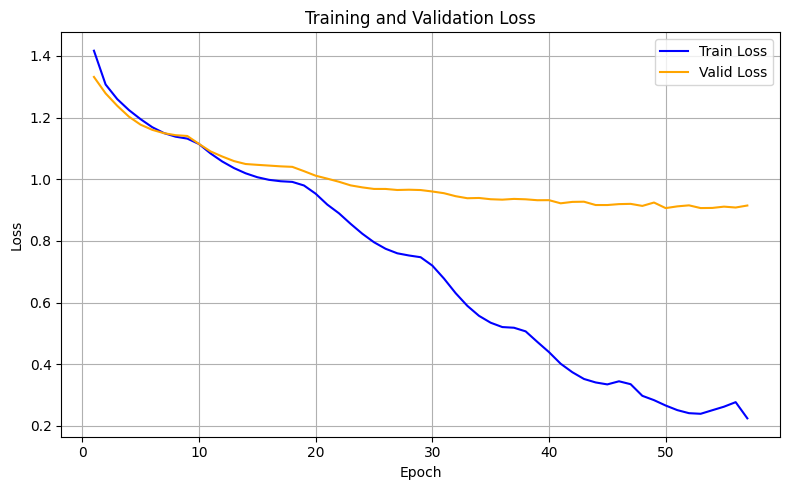

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List
import os
import csv


class LossPlotter:
    def __init__(self, csv_path: str):
        self.csv_path = Path(csv_path)
        self.data = self._load_data()

    def _load_data(self):
        if not self.csv_path.exists():
            raise FileNotFoundError(f"CSV file not found: {self.csv_path}")
        df = pd.read_csv(self.csv_path, index_col=0)  # Read row labels as index
        return df  # Make rows into columns

    def plot(self, title: str = "Training and Validation Loss", save_path= None):
        plt.figure(figsize=(8, 5))
        plt.plot(self.data.index, self.data['Train Loss'], label='Train Loss', color='blue')
        plt.plot(self.data.index, self.data['Valid Loss'], label='Valid Loss', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        if save_path:
            save_path = Path(save_path)
            save_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, format='pdf')
            print(f"[INFO] Loss plot saved to {save_path}")
        else:
            plt.show()

        plt.close()

if __name__ == "__main__":
    target_dir = "/content/drive/MyDrive/PhDwork/Segmentation"
    os.chdir(target_dir)
    loss_result_file = os.path.join(".","results",f"Results_PreProcessedCT_Uniform_Volume_Fifty_Fifty_DiceLoss_And_Strong_Augmentation","train_and_valid_loss_results.csv")
    plotter = LossPlotter(loss_result_file)
    plotter.plot()


In [ ]:
import h5py
os.chdir("/content/drive/MyDrive/PhDwork/Segmentation")
print(f"📁 Current Directory: {os.getcwd()}")
with h5py.File('./datasets/Datasets_PreprocessedCT_clipping_uniformSpacing_With_Empty_NonEmpty_slices_In_Train/train_dataset.hdf5', 'r') as f:
    print(list(f.keys()))